In [1]:
# Exports QuantumCollocation, NamedTrajectories, and TrajectoryIndexingUtils
using Piccolo
using LinearAlgebra

# Plots
using CairoMakie

In [2]:
const Units = 1e9
const MHz = 1e6 / Units
const GHz = 1e9 / Units
const ns = 1e-9 * Units
const μs = 1e-6 * Units

const n_qubits = 1
const n_levels = 2

t_f = 10 * ns
n_steps = 101
times = range(0, t_f, n_steps)  # Alternative: collect(0:Δt:t_f)
Δt = times[2] - times[1]

0.1

In [3]:
# Operators
Paulis = Dict(
    "I" => Matrix{ComplexF64}(I, 2, 2),
    "X" => Matrix{ComplexF64}([0 1; 1 0]),
    "Y" => Matrix{ComplexF64}([0 -im; im 0]),
    "Z" => Matrix{ComplexF64}([1 0; 0 -1]),
)
Rx(theta)  = kron(Paulis["I"],exp(-im * theta * Paulis["X"]/2))
Ry(theta)  = kron(Paulis["I"],exp(-im * theta * Paulis["Y"]/2))
Rz(theta)  =  kron(Paulis["I"],exp(-im * theta * Paulis["Z"]/2));

In [4]:
a = [0 1; 0 0]
ad = transpose(a)
a0  = kron(a,Paulis["I"])
ad0  = kron(ad,Paulis["I"])
a1  = kron(Paulis["I"],a)
ad1  = kron(Paulis["I"],ad);

In [5]:
H_drift = [ ]
H_drives = [
    ad0 * a0,
    ad1 * a1,
    a0+ad0,
    im * (a0-ad0),
    a1+ad1,
    im * (a1-ad1),
    ad0 * a1 + a0 * ad1
]
system = QuantumSystem(H_drives);

In [6]:
PICO_max_iter = 100

# Shape the cost function with weights on states and controls
Q = 100.
R = 1e-4

# Add control bounds
a_bound = 2 * π * 100 * MHz
dda_bound = .02
initial = nothing
infidelities = []
trajectories = []
for i in 0:20
    target = Rx(i*pi/10)
    println("Angle "*string(i*pi/10))
    println("-----------------------")
    p = UnitarySmoothPulseProblem(
        system,
        target,
        n_steps,
        Δt;
        a_bound=a_bound,
        dda_bound=dda_bound,
        Q=Q,
        R=R,
        verbose=true,
        hessian_approximation=true,
        pade_order=10,
        free_time=true,
        timesteps_all_equal=false,
        subspace=[1,2,3,4],
        max_iter=PICO_max_iter,
        #init_trajectory=initial
    )
    solve!(p)

    result = copy(p.trajectory)
    initial = result
    push!(trajectories,result)
    states = map(iso_vec_to_operator, eachslice(result[:Ũ⃗], dims=2))
    println("Infidelity " *string(unitary_infidelity(result[:Ũ⃗][:, end], operator_to_iso_vec(target))))
    rollout_states = unitary_rollout(result, system; integrator=exp)
    ΔUs = map(norm, eachslice(rollout_states .- result[:Ũ⃗], dims=2))
    println("Rollout Error "*string(maximum(ΔUs)))
    println("Infidelity "*string(unitary_infidelity(rollout_states[:, end], operator_to_iso_vec(target))))
    push!(infidelities,unitary_infidelity(rollout_states[:, end], operator_to_iso_vec(target)))

end

Angle 0.0
-----------------------
    building dynamics from integrators...
        constructing knot point dynamics functions...
        determining dynamics derivative structure...
            computing jacobian sparsity...
            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
************************************************************************

  71  1.7611316e-07 8.04e-08 2.46e+01  -4.1 2.07e-03    -  1.00e+00 1.00e+00h  1
  72  1.8006224e-07 1.51e-07 2.51e+01  -4.1 7.05e-03    -  1.00e+00 2.50e-01h  3
  73  2.4038101e-07 1.42e-07 2.50e+01  -4.1 1.54e-03    -  1.00e+00 6.25e-02h  5
  74  2.8492290e-07 1.14e-07 2.50e+01  -4.1 2.75e-03    -  1.00e+00 2.50e-01h  3
  75  3.5520984e-07 6.52e-08 2.50e+01  -4.1 1.50e-03    -  1.00e+00 5.00e-01h  2
  76  5.2411679e-08 7.65e-08 2.51e+01  -4.1 1.61e-03    -  1.00e+00 1.00e+00h  1
  77  9.0892149e-08 5.70e-08 2.49e+01  -4.1 1.37e-03    -  1.00e+00 1.00e+00h  1
  78  2.5465613e-07 4.80e-08 2.49e+01  -4.1 1.85e-03    -  1.00e+00 5.00e-01h  2
  79  2.2033714e-07 8.35e-08 2.53e+01  -4.1 3.85e-03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.7802753e-07 5.99e-08 2.53e+01  -4.1 2.19e-03    -  1.00e+00 5.00e-01h  2
  81  9.0473538e-07 4.31e-08 2.51e+01  -4.0 1.53e-03    -  1.00e+00 5.00e-01h  2
  82  1.5667468e-07 2.31e-07

  32  8.1684622e-05 2.92e-06 2.47e+01  -4.1 1.26e-02    -  1.00e+00 5.00e-01h  2
  33  4.6795179e-05 3.06e-06 2.46e+01  -4.0 1.02e-02    -  1.00e+00 1.00e+00h  1
  34  8.2835099e-06 3.24e-06 2.48e+01  -4.0 2.20e-02    -  1.00e+00 5.00e-01h  2
  35  9.6416875e-06 1.73e-06 2.46e+01  -4.0 5.64e-03    -  1.00e+00 5.00e-01h  2
  36  1.5267436e-05 1.47e-06 2.48e+01  -4.0 1.67e-02    -  1.00e+00 2.50e-01h  3
  37  7.0850490e-06 2.78e-06 2.48e+01  -4.0 1.62e-02    -  1.00e+00 5.00e-01h  2
  38  1.0553626e-05 4.58e-06 2.46e+01  -4.1 2.03e-02    -  1.00e+00 1.00e+00h  1
  39  6.3098073e-06 2.41e-06 2.46e+01  -4.1 1.41e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.1427641e-05 2.01e-06 2.47e+01  -4.1 1.89e-02    -  1.00e+00 2.50e-01h  3
  41  8.5951677e-06 1.62e-06 2.48e+01  -4.1 1.12e-02    -  1.00e+00 2.50e-01h  3
  42  2.7119190e-06 1.70e-06 2.46e+01  -4.1 3.26e-02    -  1.00e+00 1.25e-01h  4
  43  8.6012168e-06 1.49e-06

   1  1.5464979e-01 8.69e-01 2.38e+01  -0.9 7.52e-01    -  1.78e-02 2.98e-01f  1
   2  5.9209983e-01 2.79e-01 2.31e+01  -1.2 5.09e-01    -  2.74e-01 6.79e-01f  1
   3  2.6396239e-01 6.25e-03 2.08e+01  -1.2 1.71e-01    -  9.77e-01 1.00e+00f  1
   4  1.5086851e+00 1.36e-03 2.83e+01  -1.8 2.37e-01    -  1.00e+00 1.00e+00h  1
   5  2.6677596e-01 4.46e-04 2.37e+01  -2.3 1.57e-01    -  1.00e+00 1.00e+00f  1
   6  2.3539629e-01 9.46e-04 3.10e+01  -2.0 7.38e-02    -  9.91e-01 4.94e-01f  1
   7  4.8216007e-02 3.40e-04 1.47e+01  -2.3 5.62e-02    -  1.00e+00 1.00e+00h  1
   8  6.6637731e-02 3.35e-04 3.39e+01  -2.5 1.75e-01    -  1.00e+00 1.61e-01h  3
   9  3.7366540e-02 8.53e-05 1.23e+01  -2.9 4.55e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1975524e-02 6.61e-05 4.57e+01  -3.7 5.24e-02    -  1.00e+00 5.00e-01h  2
  11  3.4430381e-02 2.31e-05 2.57e+01  -4.0 1.98e-02    -  1.00e+00 1.00e+00h  1
  12  1.0037603e-02 4.54e-05

  94  5.1159927e-05 2.44e-06 2.46e+01  -4.1 7.42e-03    -  1.00e+00 1.00e+00h  1
  95  3.4118404e-04 4.75e-05 2.42e+01  -4.1 4.90e-02    -  1.00e+00 1.00e+00h  1
  96  2.6102281e-04 2.74e-05 2.32e+01  -4.1 4.23e-02    -  1.00e+00 5.00e-01h  2
  97  6.9880744e-05 2.11e-05 2.43e+01  -4.1 2.04e-02    -  1.00e+00 2.50e-01h  3
  98  1.6856662e-04 1.29e-05 2.37e+01  -4.1 1.49e-02    -  1.00e+00 1.00e+00h  1
  99  7.1662391e-05 1.49e-05 2.40e+01  -4.1 2.15e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.7835918e-05 1.24e-05 2.36e+01  -4.1 3.77e-02    -  1.00e+00 5.00e-01h  2

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   7.7835918177879162e-05    7.7835918177879162e-05
Dual infeasibility......:   2.3589965033869746e+01    2.3589965033869746e+01
Constraint violation....:   1.2375642998496694e-05    1.2375642998496694e-05
Variable bound vio

  55  1.3875173e-05 5.03e-08 2.26e+01  -4.0 4.66e-03    -  1.00e+00 2.50e-01h  3
  56  1.3746553e-05 4.61e-08 2.26e+01  -4.1 2.70e-03    -  1.00e+00 2.50e-01h  3
  57  1.4029514e-05 4.62e-08 2.26e+01  -4.1 4.13e-03    -  1.00e+00 2.50e-01h  3
  58  1.4335816e-05 4.14e-08 2.19e+01  -4.1 3.57e-03    -  1.00e+00 2.50e-01h  3
  59  1.3845244e-05 3.28e-08 2.20e+01  -4.1 7.90e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.4205076e-05 1.93e-08 2.28e+01  -4.0 7.24e-04    -  1.00e+00 1.00e+00h  1
  61  1.4810881e-05 4.49e-08 2.28e+01  -4.0 3.00e-03    -  1.00e+00 5.00e-01h  2
  62  1.4571301e-05 1.08e-07 2.18e+01  -4.1 2.41e-03    -  1.00e+00 1.00e+00h  1
  63  1.5068042e-05 1.58e-07 2.25e+01  -4.1 2.76e-03    -  1.00e+00 1.00e+00h  1
  64  1.5906190e-05 1.67e-07 2.26e+01  -4.1 1.24e-02    -  1.00e+00 1.25e-01h  4
  65  1.4403362e-05 1.59e-07 2.20e+01  -4.1 4.99e-03    -  1.00e+00 2.50e-01h  3
  66  1.4402292e-05 1.01e-07

  16  4.3585288e-04 2.06e-05 1.96e+01  -3.8 1.11e-02    -  1.00e+00 1.00e+00h  1
  17  4.1403694e-04 1.95e-05 2.07e+01  -4.0 9.50e-02    -  1.00e+00 6.25e-02h  5
  18  3.8520924e-05 3.28e-06 2.05e+01  -4.0 8.22e-03    -  1.00e+00 1.00e+00h  1
  19  3.7301220e-04 3.14e-06 2.00e+01  -4.0 2.76e-02    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.9906266e-04 5.64e-06 1.98e+01  -4.0 4.12e-03    -  1.00e+00 1.00e+00h  1
  21  2.2715591e-04 5.46e-06 2.05e+01  -4.1 8.11e-02    -  1.00e+00 3.12e-02h  6
  22  2.5165687e-04 2.92e-06 2.04e+01  -4.0 8.53e-03    -  1.00e+00 1.00e+00h  1
  23  1.2367892e-04 2.68e-06 2.01e+01  -4.0 2.79e-02    -  1.00e+00 1.25e-01h  4
  24  6.9928951e-05 1.83e-06 2.04e+01  -4.0 4.10e-03    -  1.00e+00 1.00e+00h  1
  25  6.9304935e-05 2.01e-06 2.01e+01  -4.0 5.19e-03    -  1.00e+00 1.00e+00h  1
  26  2.7617072e-05 1.39e-06 2.00e+01  -4.1 4.73e-03    -  1.00e+00 1.00e+00h  1
  27  4.4074752e-05 1.33e-06

            computing jacobian sparsity...
            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    81906
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1501
                     variables with only upper bounds:        0
Total number of equality constraints.....

  78  3.8872135e-05 3.17e-07 1.79e+01  -4.0 3.41e-03    -  1.00e+00 5.00e-01h  2
  79  4.7569127e-05 1.97e-06 1.78e+01  -4.0 7.02e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  7.0685843e-05 8.58e-07 1.78e+01  -4.1 7.34e-03    -  1.00e+00 1.00e+00H  1
  81  4.5700617e-05 7.57e-07 1.75e+01  -4.1 1.04e-02    -  1.00e+00 2.50e-01h  3
  82  3.6770686e-05 3.89e-07 1.77e+01  -4.1 3.13e-03    -  1.00e+00 1.00e+00h  1
  83  4.1602383e-05 1.25e-06 1.78e+01  -4.1 6.99e-03    -  1.00e+00 1.00e+00h  1
  84  3.7665674e-05 3.39e-06 1.76e+01  -4.1 7.77e-03    -  1.00e+00 1.00e+00h  1
  85  3.4918037e-05 1.73e-06 1.78e+01  -4.1 9.53e-03    -  1.00e+00 1.00e+00h  1
  86  3.4989056e-05 1.31e-06 1.77e+01  -4.1 6.87e-03    -  1.00e+00 2.50e-01h  3
  87  4.0107170e-05 7.49e-07 1.76e+01  -4.1 3.29e-03    -  1.00e+00 5.00e-01h  2
  88  3.4694270e-05 4.61e-07 1.76e+01  -4.1 3.24e-03    -  1.00e+00 1.00e+00h  1
  89  4.2779548e-05 3.81e-07

  39  4.7602920e-05 2.91e-07 2.01e+01  -4.1 6.04e-03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.8597920e-05 2.42e-07 2.04e+01  -4.0 4.56e-03    -  1.00e+00 2.50e-01h  3
  41  4.9067375e-05 2.59e-07 2.06e+01  -4.0 3.62e-03    -  1.00e+00 1.00e+00h  1
  42  4.8411425e-05 1.66e-07 1.99e+01  -4.1 1.90e-03    -  1.00e+00 1.00e+00h  1
  43  4.8050687e-05 1.26e-07 2.06e+01  -4.0 2.73e-03    -  1.00e+00 2.50e-01h  3
  44  4.7869832e-05 8.40e-08 1.96e+01  -4.0 1.49e-03    -  1.00e+00 1.00e+00h  1
  45  4.7799626e-05 1.40e-07 2.10e+01  -4.0 1.81e-03    -  1.00e+00 1.00e+00h  1
  46  5.6331380e-05 5.19e-06 1.93e+01  -4.1 9.83e-03    -  1.00e+00 1.00e+00h  1
  47  5.5572669e-05 3.99e-06 1.94e+01  -4.1 6.36e-03    -  1.00e+00 2.50e-01h  3
  48  5.7853048e-05 3.55e-06 2.02e+01  -4.1 7.62e-03    -  1.00e+00 1.00e+00h  1
  49  5.0887639e-05 3.14e-06 2.01e+01  -4.1 8.10e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

   1  1.3632407e+01 9.67e-01 4.36e+01  -0.7 7.34e-01    -  2.15e-02 2.06e-01f  1
   2  1.3014490e+01 9.01e-01 4.22e+01  -0.2 8.23e-01    -  8.52e-01 6.83e-02f  1
   3  2.8846487e+00 2.77e-02 2.41e+01   0.1 5.17e-01    -  4.43e-01 9.90e-01f  1
   4  2.3055891e+00 9.52e-04 1.19e+01  -0.2 1.40e-01    -  8.52e-01 1.00e+00f  1
   5  1.3524602e-01 2.60e-04 6.01e+00  -1.0 1.23e-01    -  9.59e-01 1.00e+00f  1
   6  7.3862135e-02 6.30e-05 3.11e+00  -1.8 1.56e-01    -  9.48e-01 1.00e+00H  1
   7  3.5563215e-02 3.18e-05 4.61e+01  -2.5 3.09e-02    -  9.97e-01 5.00e-01h  2
   8  1.8829317e-02 1.31e-06 3.19e+01  -4.0 4.85e-03    -  1.00e+00 1.00e+00h  1
   9  1.9214575e-03 2.39e-06 2.56e+01  -4.0 9.98e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.6019693e-04 2.46e-06 2.15e+01  -4.0 1.70e-02    -  1.00e+00 2.50e-01h  3
  11  3.5785736e-04 2.79e-06 2.36e+01  -4.0 7.49e-03    -  1.00e+00 1.00e+00h  1
  12  1.8173364e-04 3.76e-06

  94  1.0469059e-04 1.21e-09 2.22e-03  -4.1 1.11e-04    -  1.00e+00 1.00e+00h  1
  95  7.6265232e-05 1.68e-08 2.26e+01  -4.0 2.67e-04    -  1.00e+00 1.00e+00h  1
  96  7.4072188e-05 3.83e-08 2.23e+01  -4.1 4.44e-04    -  1.00e+00 1.00e+00h  1
  97  6.5940756e-05 3.51e-08 1.38e+01  -4.1 4.21e-04    -  1.00e+00 1.00e+00h  1
  98  7.1810441e-05 8.96e-09 9.33e-04  -4.1 1.51e-04    -  1.00e+00 1.00e+00h  1
  99  6.5413696e-05 2.48e-09 6.00e-04  -4.1 1.30e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.1699593e-05 3.11e-09 2.55e-05  -6.1 2.68e-04    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   6.1699593280325387e-05    6.1699593280325387e-05
Dual infeasibility......:   2.5474074134354062e-05    2.5474074134354062e-05
Constraint violation....:   3.1051560211992069e-09    3.1051560211992069e-09
Variable bound vio

  55  7.9240860e-05 2.93e-06 2.43e+01  -4.0 6.57e-03    -  1.00e+00 1.00e+00h  1
  56  8.7510791e-05 2.38e-06 2.32e+01  -4.1 1.61e-02    -  1.00e+00 2.50e-01h  3
  57  1.4244360e-04 2.28e-06 2.39e+01  -4.1 8.12e-03    -  1.00e+00 1.00e+00h  1
  58  9.1902869e-05 1.04e-05 2.38e+01  -4.1 2.11e-02    -  1.00e+00 1.00e+00h  1
  59  8.6849646e-05 1.02e-05 2.37e+01  -4.1 2.38e-02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  9.6059331e-05 7.61e-06 2.38e+01  -4.1 2.35e-02    -  1.00e+00 5.00e-01h  2
  61  7.7077722e-05 4.68e-06 2.38e+01  -4.1 1.39e-02    -  1.00e+00 1.00e+00h  1
  62  8.2748930e-05 5.41e-06 2.37e+01  -4.1 2.15e-02    -  1.00e+00 5.00e-01h  2
  63  7.7769429e-05 1.61e-06 2.38e+01  -4.1 8.55e-03    -  1.00e+00 1.00e+00h  1
  64  9.0135828e-05 1.87e-06 2.37e+01  -4.1 1.39e-02    -  1.00e+00 5.00e-01h  2
  65  8.9936855e-05 1.97e-06 2.36e+01  -4.1 1.15e-02    -  1.00e+00 5.00e-01h  2
  66  8.3519354e-05 1.27e-06

  16  4.1522656e-03 8.13e-05 3.75e+01  -4.1 5.58e-02    -  4.23e-01 1.18e-01h  3
  17  4.5677534e-04 3.45e-06 2.50e+01  -4.1 8.22e-03    -  1.00e+00 1.00e+00h  1
  18  1.6922178e-03 5.69e-07 1.83e+01  -4.1 1.83e-03    -  1.00e+00 1.00e+00h  1
  19  8.4650728e-04 5.70e-06 2.30e+01  -4.0 6.91e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.2911941e-04 5.67e-06 2.65e+01  -4.1 3.31e-01    -  6.80e-01 6.98e-03h  7
  21  4.2701599e-04 8.75e-07 2.05e+01  -4.1 1.72e-03    -  1.00e+00 1.00e+00h  1
  22  2.4440000e-04 2.45e-07 1.95e+01  -4.0 2.06e-03    -  1.00e+00 1.00e+00h  1
  23  1.3847927e-04 2.27e-07 3.08e+01  -4.0 8.30e-03    -  1.00e+00 1.25e-01h  4
  24  1.0972268e-04 2.31e-06 2.43e+01  -4.0 4.53e-03    -  1.00e+00 1.00e+00h  1
  25  1.3542325e-04 2.27e-06 2.55e+01  -4.1 1.01e-02    -  1.00e+00 1.25e-01h  4
  26  1.0378598e-04 5.22e-07 2.61e+01  -4.1 1.87e-03    -  1.00e+00 1.00e+00h  1
  27  1.6714478e-04 2.81e-05

            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    81906
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1501
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4600
Total number of ineq

  78  1.1229829e-04 1.16e-07 2.56e+01  -4.1 1.30e-03    -  1.00e+00 1.00e+00h  1
  79  1.1158113e-04 8.88e-08 2.56e+01  -4.1 2.06e-03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.1164125e-04 6.64e-08 2.43e+01  -4.1 1.62e-03    -  1.00e+00 2.50e-01h  3
  81  1.1173715e-04 5.15e-08 2.56e+01  -4.1 2.43e-03    -  1.00e+00 2.50e-01h  3
  82  1.1167547e-04 4.60e-08 2.43e+01  -4.1 1.01e-03    -  1.00e+00 5.00e-01h  2
  83  1.1163455e-04 5.43e-08 2.43e+01  -4.1 2.13e-03    -  1.00e+00 2.50e-01h  3
  84  1.1120465e-04 4.14e-08 2.57e+01  -4.1 1.31e-03    -  1.00e+00 2.50e-01h  3
  85  1.1160587e-04 4.50e-08 2.41e+01  -4.1 5.86e-04    -  1.00e+00 1.00e+00h  1
  86  1.1145139e-04 1.89e-08 2.34e+01  -4.1 6.05e-04    -  1.00e+00 1.00e+00h  1
  87  1.1156042e-04 1.85e-08 2.66e+01  -4.1 3.44e-03    -  1.00e+00 6.25e-02h  5
  88  1.1130738e-04 1.57e-08 2.69e+01  -4.1 4.68e-04    -  1.00e+00 1.00e+00h  1
  89  1.1138200e-04 1.48e-08

  39  1.4399368e-04 4.55e-07 2.49e+01  -4.0 3.42e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.4246113e-04 3.09e-07 2.38e+01  -4.0 2.00e-03    -  1.00e+00 5.00e-01h  2
  41  1.3909750e-04 1.59e-06 2.37e+01  -4.0 3.66e-03    -  1.00e+00 1.00e+00h  1
  42  3.4493837e-04 1.11e-06 2.51e+01  -4.1 1.03e-02    -  1.00e+00 5.00e-01h  2
  43  1.4133643e-04 1.06e-06 2.47e+01  -4.1 5.02e-03    -  1.00e+00 1.00e+00h  1
  44  1.3893493e-04 3.99e-07 2.39e+01  -4.1 3.87e-03    -  1.00e+00 1.00e+00h  1
  45  1.3525027e-04 4.19e-07 2.50e+01  -4.1 3.13e-03    -  1.00e+00 1.00e+00h  1
  46  1.3855728e-04 7.26e-07 2.49e+01  -4.1 4.27e-03    -  1.00e+00 1.00e+00h  1
  47  1.6777279e-04 8.09e-06 2.49e+01  -4.1 3.18e-02    -  1.00e+00 5.00e-01h  2
  48  1.5722175e-04 1.89e-06 2.42e+01  -4.1 8.11e-03    -  1.00e+00 1.00e+00h  1
  49  1.3620922e-04 1.15e-06 2.42e+01  -4.1 6.30e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

   1  1.7419167e+00 9.04e-01 2.38e+01  -0.8 7.13e-01    -  1.91e-02 2.58e-01f  1
   2  1.8266447e+00 8.28e-01 2.31e+01  -0.3 9.19e-01    -  4.28e-01 8.38e-02f  1
   3  1.0860536e-01 3.36e-01 1.58e+01  -0.4 5.87e-01    -  4.27e-01 5.94e-01f  1
   4  4.3985129e-01 2.00e-01 3.73e+01  -0.6 3.13e-01    -  9.31e-01 4.05e-01h  1
   5  3.1974408e+00 3.75e-03 1.37e+01  -1.1 1.57e-01    -  9.98e-01 1.00e+00h  1
   6  2.0923919e+00 7.33e-05 2.93e+01  -1.6 4.16e-02    -  9.99e-01 1.00e+00f  1
   7  1.0977807e+00 1.25e-04 2.00e+01  -2.1 5.58e-02    -  1.00e+00 1.00e+00f  1
   8  2.3668706e-01 5.96e-04 3.01e+01  -2.4 1.21e-01    -  1.00e+00 9.44e-01f  1
   9  1.0197131e+00 3.48e-04 3.81e+01  -2.2 1.09e-01    -  6.55e-01 6.93e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.1730264e-01 4.47e-04 2.43e+01  -2.3 5.36e-02    -  1.00e+00 1.00e+00f  1
  11  1.6533468e-01 3.19e-04 2.58e+01  -2.5 8.31e-02    -  7.56e-01 6.34e-01F  1
  12  6.9014511e-02 6.42e-05

  94  1.5272607e-04 3.05e-07 2.39e+01  -4.1 7.65e-03    -  1.00e+00 2.50e-01h  3
  95  1.5297939e-04 2.96e-07 2.39e+01  -4.1 6.87e-03    -  1.00e+00 2.50e-01h  3
  96  1.5404277e-04 2.66e-07 2.39e+01  -4.1 3.72e-03    -  1.00e+00 5.00e-01h  2
  97  1.5324403e-04 1.53e-07 2.42e+01  -4.0 2.82e-03    -  1.00e+00 1.00e+00H  1
  98  1.5332883e-04 2.38e-07 2.28e+01  -4.0 2.17e-03    -  1.00e+00 1.00e+00h  1
  99  1.5264974e-04 2.35e-07 2.44e+01  -4.1 2.44e-02    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5226356e-04 1.74e-07 2.30e+01  -4.1 2.66e-03    -  1.00e+00 5.00e-01h  2

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   1.5226356492232959e-04    1.5226356492232959e-04
Dual infeasibility......:   2.2995899645680996e+01    2.2995899645680996e+01
Constraint violation....:   1.7351044523383763e-07    1.7351044523383763e-07
Variable bound vio

  55  4.2408450e-04 1.34e-05 2.17e+01  -4.1 1.98e-02    -  1.00e+00 1.00e+00h  1
  56  2.0339567e-04 1.27e-05 2.17e+01  -4.1 3.39e-02    -  1.00e+00 5.00e-01h  2
  57  1.9357977e-04 6.16e-05 2.16e+01  -4.1 3.90e-02    -  1.00e+00 1.00e+00h  1
  58  2.2556115e-04 3.32e-05 2.16e+01  -4.1 2.86e-02    -  1.00e+00 1.00e+00h  1
  59  2.0807148e-04 2.15e-05 2.17e+01  -4.1 5.03e-02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.8709078e-04 3.50e-05 2.16e+01  -4.1 2.72e-02    -  1.00e+00 1.00e+00h  1
  61  2.0489850e-04 2.94e-05 2.17e+01  -4.1 7.14e-02    -  1.00e+00 2.50e-01h  3
  62  1.8612609e-04 2.12e-05 2.17e+01  -4.1 3.03e-02    -  1.00e+00 1.00e+00h  1
  63  2.1316220e-04 8.19e-06 2.16e+01  -4.1 1.47e-02    -  1.00e+00 1.00e+00h  1
  64  1.8589392e-04 3.77e-06 2.17e+01  -4.1 1.28e-02    -  1.00e+00 1.00e+00h  1
  65  1.8470960e-04 7.12e-06 2.16e+01  -4.1 2.77e-02    -  1.00e+00 5.00e-01h  2
  66  2.0135013e-04 1.90e-05

  16  5.3259616e-04 1.66e-06 2.02e+01  -4.0 5.66e-03    -  1.00e+00 5.00e-01h  2
  17  4.5468656e-04 8.31e-07 1.88e+01  -4.0 2.76e-03    -  1.00e+00 1.00e+00h  1
  18  2.6646454e-04 2.51e-06 1.55e+01  -4.0 2.45e-03    -  1.00e+00 1.00e+00h  1
  19  2.4576615e-04 2.59e-06 2.51e+01  -4.0 2.00e-02    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.1033695e-04 3.14e-08 1.95e+01  -4.0 7.47e-04    -  1.00e+00 1.00e+00h  1
  21  2.0501753e-04 7.30e-08 2.45e+01  -4.0 6.66e-04    -  1.00e+00 1.00e+00h  1
  22  2.0412162e-04 7.92e-08 1.06e+01  -4.1 7.04e-04    -  1.00e+00 1.00e+00H  1
  23  2.3206552e-04 1.21e-06 3.41e+01  -4.1 2.14e-03    -  1.00e+00 1.00e+00h  1
  24  2.3976282e-04 3.01e-05 1.31e+01  -4.1 9.43e-03    -  1.00e+00 1.00e+00h  1
  25  2.3648479e-04 2.38e-05 2.65e+01  -4.1 7.00e-03    -  1.00e+00 2.50e-01h  3
  26  2.5615007e-04 1.40e-05 1.76e+01  -4.1 7.07e-03    -  1.00e+00 1.00e+00h  1
  27  2.2967399e-04 7.41e-06

            computing jacobian sparsity...
            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    81906
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1501
                     variables with only upper bounds:        0
Total number of equality constraints.....

  78  2.2199795e-04 3.76e-06 1.78e+01  -4.1 8.87e-03    -  1.00e+00 1.00e+00h  1
  79  2.2188118e-04 1.91e-06 1.76e+01  -4.1 5.38e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.1688545e-04 1.77e-06 1.78e+01  -4.1 3.76e-02    -  1.00e+00 6.25e-02h  5
  81  2.1546633e-04 1.56e-06 1.76e+01  -4.1 1.51e-02    -  1.00e+00 2.50e-01h  3
  82  2.1522257e-04 9.24e-07 1.76e+01  -4.1 5.00e-03    -  1.00e+00 5.00e-01h  2
  83  2.1695134e-04 5.69e-07 1.78e+01  -4.1 7.71e-03    -  1.00e+00 5.00e-01h  2
  84  2.1610105e-04 5.68e-07 1.78e+01  -4.1 1.94e-02    -  1.00e+00 6.25e-02h  5
  85  2.1664008e-04 4.23e-07 1.78e+01  -4.1 3.61e-03    -  1.00e+00 5.00e-01h  2
  86  2.1747492e-04 3.42e-07 1.79e+01  -4.1 7.40e-03    -  1.00e+00 2.50e-01h  3
  87  2.1611677e-04 2.99e-07 1.75e+01  -4.1 1.19e-02    -  1.00e+00 1.25e-01h  4
  88  2.1550534e-04 1.47e-07 1.79e+01  -4.1 1.25e-03    -  1.00e+00 1.00e+00h  1
  89  2.1622172e-04 2.24e-07

  39  2.4468711e-04 2.01e-07 1.95e+01  -4.0 1.00e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.4472126e-04 1.71e-07 2.07e+01  -4.0 4.39e-03    -  1.00e+00 2.50e-01h  3
  41  2.4107626e-04 5.94e-07 2.09e+01  -4.1 4.97e-03    -  1.00e+00 1.00e+00h  1
  42  2.4423241e-04 5.36e-07 1.96e+01  -4.1 1.29e-02    -  1.00e+00 1.25e-01h  4
  43  2.4883029e-04 5.35e-07 2.08e+01  -4.1 2.11e-02    -  1.00e+00 3.12e-02h  6
  44  2.3983860e-04 3.31e-07 1.98e+01  -4.1 2.50e-03    -  1.00e+00 1.00e+00h  1
  45  2.4344821e-04 4.47e-07 2.06e+01  -4.1 2.63e-03    -  1.00e+00 1.00e+00h  1
  46  2.3970058e-04 2.60e-07 2.05e+01  -4.1 2.04e-03    -  1.00e+00 1.00e+00h  1
  47  2.4378139e-04 1.27e-07 1.98e+01  -4.1 2.58e-03    -  1.00e+00 5.00e-01h  2
  48  2.4150585e-04 4.93e-07 1.98e+01  -4.1 2.88e-03    -  1.00e+00 1.00e+00h  1
  49  2.4013456e-04 4.55e-07 2.07e+01  -4.1 9.19e-03    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr 

   1  2.3875373e+00 9.21e-01 2.22e+01  -0.8 7.20e-01    -  2.11e-02 2.26e-01f  1
   2  2.5524148e+00 8.40e-01 2.14e+01  -0.3 9.85e-01    -  3.89e-01 8.72e-02f  1
   3  1.4718355e+00 5.38e-01 1.60e+01  -0.4 6.08e-01    -  3.32e-01 3.60e-01f  1
   4  1.2000608e+00 4.14e-01 3.59e+01  -0.5 4.82e-01    -  7.41e-01 2.30e-01f  1
   5  1.7111432e+00 2.75e-01 6.50e+01  -0.2 3.45e-01    -  1.00e+00 3.35e-01f  1
   6  4.2469837e+00 2.32e-02 4.87e+01  -0.2 1.99e-01    -  8.92e-01 9.16e-01h  1
   7  6.6111201e-01 1.64e-04 1.29e+00  -1.1 5.59e-02    -  9.95e-01 1.00e+00f  1
   8  4.9157835e-01 1.87e-04 4.45e+01  -2.1 7.87e-02    -  9.82e-01 1.00e+00f  1
   9  3.1301855e-02 3.81e-05 5.95e+00  -3.1 4.46e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4367881e-03 3.82e-05 3.88e+01  -3.5 3.84e-01    -  1.00e+00 1.68e-02f  6
  11  2.3657095e-02 1.44e-05 2.34e+01  -3.2 2.57e-02    -  1.00e+00 1.00e+00h  1
  12  1.4929903e-02 8.50e-06

  94  2.7945718e-04 2.55e-05 2.22e+01  -4.1 1.46e-01    -  1.00e+00 6.25e-02h  5
  95  2.6740689e-04 1.70e-05 2.22e+01  -4.1 3.95e-02    -  1.00e+00 5.00e-01h  2
  96  2.6594183e-04 1.23e-05 2.23e+01  -4.1 2.62e-02    -  1.00e+00 5.00e-01h  2
  97  2.7122369e-04 1.31e-05 2.23e+01  -4.1 2.14e-02    -  1.00e+00 1.00e+00h  1
  98  2.6626993e-04 1.04e-05 2.22e+01  -4.1 3.52e-02    -  1.00e+00 2.50e-01h  3
  99  2.6393187e-04 1.19e-05 2.23e+01  -4.1 5.84e-02    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.6181789e-04 8.88e-06 2.23e+01  -4.1 2.68e-02    -  1.00e+00 2.50e-01h  3

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   2.6181789156344196e-04    2.6181789156344196e-04
Dual infeasibility......:   2.2336572912962854e+01    2.2336572912962854e+01
Constraint violation....:   8.8822992067028039e-06    8.8822992067028039e-06
Variable bound vio

  55  3.2438633e-04 1.63e-05 2.35e+01  -4.1 2.10e-02    -  1.00e+00 1.00e+00h  1
  56  2.8885999e-04 9.44e-06 2.36e+01  -4.1 2.33e-02    -  1.00e+00 1.00e+00h  1
  57  3.0802076e-04 7.70e-06 2.35e+01  -4.1 4.03e-02    -  1.00e+00 2.50e-01h  3
  58  3.0018077e-04 7.20e-06 2.35e+01  -4.1 3.09e-02    -  1.00e+00 5.00e-01h  2
  59  2.9409333e-04 1.65e-05 2.37e+01  -4.1 1.10e-01    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.1079562e-04 9.88e-06 2.37e+01  -4.1 1.74e-02    -  1.00e+00 5.00e-01h  2
  61  2.9525488e-04 8.99e-06 2.35e+01  -4.1 3.57e-02    -  1.00e+00 5.00e-01h  2
  62  2.9247174e-04 3.45e-06 2.36e+01  -4.1 1.42e-02    -  1.00e+00 1.00e+00h  1
  63  2.9376798e-04 6.26e-06 2.35e+01  -4.1 2.91e-02    -  1.00e+00 5.00e-01h  2
  64  2.9637619e-04 6.44e-06 2.35e+01  -4.1 1.95e-02    -  1.00e+00 5.00e-01h  2
  65  2.9002018e-04 5.07e-06 2.35e+01  -4.1 2.00e-02    -  1.00e+00 5.00e-01h  2
  66  2.9901900e-04 3.15e-06

  16  1.4128635e-02 1.20e-05 2.34e+01  -4.0 1.03e-02    -  1.00e+00 1.00e+00h  1
  17  4.3605872e-03 1.54e-05 2.01e+01  -4.0 1.14e-02    -  1.00e+00 1.00e+00h  1
  18  5.1353011e-04 1.87e-05 2.05e+01  -4.0 5.56e-02    -  1.00e+00 1.41e-01h  3
  19  6.1925243e-04 1.03e-05 8.11e+00  -4.0 8.62e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.4461223e-03 7.61e-07 1.45e-01  -4.0 1.26e-02    -  9.90e-01 1.00e+00H  1
  21  1.1964927e-03 8.14e-06 4.94e+01  -4.0 6.06e-03    -  1.00e+00 1.00e+00h  1
  22  1.3434584e-03 1.26e-06 4.04e+01  -4.0 2.43e-03    -  1.00e+00 1.00e+00h  1
  23  1.2010159e-03 7.75e-06 1.22e+01  -4.0 5.44e-03    -  1.00e+00 1.00e+00h  1
  24  1.2111849e-03 1.12e-06 1.28e+01  -4.0 1.88e-03    -  1.00e+00 1.00e+00h  1
  25  1.1854328e-03 5.08e-06 3.97e+01  -4.0 2.90e-02    -  1.00e+00 1.79e-01h  3
  26  5.2611678e-04 7.16e-07 2.16e+01  -4.0 1.56e-03    -  1.00e+00 1.00e+00h  1
  27  3.8640718e-04 2.12e-07

            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    81906
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1501
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4600
Total number of ineq

  78  3.9069860e-04 8.87e-06 2.34e+01  -4.1 3.32e-02    -  1.00e+00 1.25e-01h  4
  79  3.9838492e-04 8.13e-06 2.36e+01  -4.1 2.12e-02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  4.0893951e-04 4.54e-05 2.36e+01  -4.1 3.37e-02    -  1.00e+00 1.00e+00h  1
  81  4.8395839e-04 7.50e-05 2.36e+01  -4.1 5.98e-02    -  1.00e+00 1.00e+00h  1
  82  4.0718010e-04 7.05e-05 2.35e+01  -4.1 8.13e-02    -  1.00e+00 5.00e-01h  2
  83  4.2324842e-04 4.79e-05 2.35e+01  -4.1 3.24e-02    -  1.00e+00 5.00e-01h  2
  84  3.9093751e-04 8.37e-05 2.35e+01  -4.1 5.31e-02    -  1.00e+00 1.00e+00h  1
  85  4.6244536e-04 4.54e-05 2.35e+01  -4.1 4.70e-02    -  1.00e+00 5.00e-01h  2
  86  3.9068872e-04 7.69e-05 2.35e+01  -4.1 6.47e-02    -  1.00e+00 1.00e+00h  1
  87  4.5399944e-04 4.09e-05 2.35e+01  -4.1 3.27e-02    -  1.00e+00 5.00e-01h  2
  88  4.0161325e-04 3.02e-05 2.35e+01  -4.1 4.07e-02    -  1.00e+00 1.00e+00h  1
  89  4.1042830e-04 2.82e-05

In [7]:
infidelities

21-element Vector{Any}:
 7.49721074583265e-5
 0.0002300914082942196
 0.0006292371948707354
 0.001268835767865406
 0.006196997420217065
 1.2963044671909785e-5
 2.5740788512917945e-6
 1.6588957985064212e-9
 5.123743811008552e-6
 0.0014565925313557715
 1.383614481875739e-7
 9.04501599954255e-5
 3.449489233697811e-6
 6.191976948155542e-5
 9.964370383475085e-6
 2.168225024190562e-6
 3.635558931125438e-5
 0.0003020050602776658
 0.000631399110572195
 0.0006240830938046837
 0.005829261325467017

In [8]:
PICO_max_iter = 100

# Shape the cost function with weights on states and controls
Q = 100.
R = 1e-4

# Add control bounds
a_bound = 2 * π * 100 * MHz
dda_bound = .02
initial = nothing
initialized_infidelities = []
initialized_trajectories = []
for i in 0:20
    println("Angle "*string(i*pi/10))
    println("-----------------------")
    p = UnitarySmoothPulseProblem(
        system,
        Rx(i*pi/10),
        n_steps,
        Δt;
        a_bound=a_bound,
        dda_bound=dda_bound,
        Q=Q,
        R=R,
        verbose=true,
        hessian_approximation=true,
        pade_order=10,
        free_time=true,
        timesteps_all_equal=false,
        subspace=[1,2,3,4],
        max_iter=PICO_max_iter,
       
    )
    solve!(p, init_traj=initial)
    result = copy(p.trajectory)
    initial = copy(result)
    push!(initialized_trajectories,initial)
    states = map(iso_vec_to_operator, eachslice(initial[:Ũ⃗], dims=2))
    println("Infidelity " *string(unitary_infidelity(initial[:Ũ⃗][:, end], operator_to_iso_vec(Rx(i*pi/10)))))
    rollout_states = unitary_rollout(initial, system; integrator=exp)
    ΔUs = map(norm, eachslice(rollout_states .- initial[:Ũ⃗], dims=2))
    println("Rollout Error "*string(maximum(ΔUs)))
    println("Infidelity "*string(unitary_infidelity(rollout_states[:, end], operator_to_iso_vec(Rx(i*pi/10)))))
    push!(initialized_infidelities,unitary_infidelity(rollout_states[:, end], operator_to_iso_vec(Rx(i*pi/10))))

end

Angle 0.0
-----------------------
    building dynamics from integrators...
        constructing knot point dynamics functions...
        determining dynamics derivative structure...
            computing jacobian sparsity...
            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    81906
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5408
                     variables with only lower bou

  76  3.6522909e-04 6.73e-06 2.37e+01  -4.1 2.11e-02    -  1.00e+00 2.50e-01h  3
  77  1.5447449e-04 2.18e-06 2.39e+01  -4.1 6.55e-03    -  1.00e+00 1.00e+00h  1
  78  5.2362998e-04 1.83e-06 2.54e+01  -4.1 2.23e-02    -  1.00e+00 2.50e-01h  3
  79  7.2305260e-05 2.94e-06 2.73e+01  -4.1 4.18e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  3.8498779e-04 2.22e-06 2.02e+01  -4.1 6.70e-03    -  1.00e+00 1.00e+00h  1
  81  1.5573811e-04 2.15e-06 2.14e+01  -4.1 7.92e-03    -  1.00e+00 5.00e-01h  2
  82  3.1022722e-05 1.87e-06 2.80e+01  -4.1 1.29e-02    -  1.00e+00 1.25e-01h  4
  83  4.4370612e-05 2.35e-06 2.35e+01  -4.1 4.99e-03    -  1.00e+00 5.00e-01h  2
  84  2.5896456e-05 8.59e-07 2.25e+01  -4.1 3.67e-03    -  1.00e+00 1.00e+00h  1
  85  6.9316080e-06 9.00e-07 2.75e+01  -4.1 1.59e-02    -  1.00e+00 2.50e-01h  3
  86  2.9857934e-06 2.04e-06 2.59e+01  -4.1 4.14e-03    -  1.00e+00 1.00e+00h  1
  87  3.3416595e-07 1.76e-06

  37  3.8683952e-06 1.37e-06 2.46e+01  -4.1 8.03e-03    -  1.00e+00 1.00e+00h  1
  38  2.1815186e-06 1.20e-06 2.48e+01  -4.1 1.34e-02    -  1.00e+00 2.50e-01h  3
  39  1.8795585e-06 1.14e-06 2.46e+01  -4.1 1.21e-02    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  7.8800192e-06 1.14e-06 2.48e+01  -4.1 1.96e-02    -  1.00e+00 1.25e-01h  4
  41  3.6473037e-06 9.56e-07 2.48e+01  -4.1 7.88e-03    -  1.00e+00 1.00e+00h  1
  42  2.1804090e-06 2.89e-07 2.46e+01  -4.1 4.94e-03    -  1.00e+00 1.00e+00h  1
  43  1.6899094e-06 3.01e-07 2.49e+01  -4.0 6.10e-03    -  1.00e+00 5.00e-01h  2
  44  3.4367445e-06 3.08e-07 2.50e+01  -4.1 6.08e-03    -  1.00e+00 5.00e-01h  2
  45  4.1099077e-06 3.24e-07 2.50e+01  -4.0 9.93e-03    -  1.00e+00 1.25e-01h  4
  46  3.7433223e-06 3.14e-07 2.51e+01  -4.0 8.98e-03    -  1.00e+00 2.50e-01h  3
  47  3.7433231e-06 2.70e-07 2.42e+01  -4.0 1.23e-02    -  1.00e+00 1.25e-01h  4
  48  2.8357856e-06 3.39e-07

   1  9.5082581e-01 3.52e-04 4.76e+01  -1.9 1.38e-01    -  9.59e-01 1.00e+00f  1
   2  7.2192382e-02 4.69e-05 8.02e+00  -2.9 4.90e-02    -  1.00e+00 1.00e+00f  1
   3  5.4373008e-02 5.98e-05 4.14e+01  -3.2 2.29e-01    -  1.00e+00 1.25e-01f  4
   4  4.6668635e-02 3.90e-05 1.93e+01  -3.5 3.77e-02    -  1.00e+00 1.00e+00h  1
   5  2.5075776e-03 7.91e-06 3.05e+01  -4.0 1.32e-02    -  1.00e+00 1.00e+00h  1
   6  1.2023118e-01 3.60e-06 4.64e+01  -4.0 3.55e-02    -  1.00e+00 1.00e+00H  1
   7  4.9332444e-02 9.51e-06 3.71e+01  -4.0 1.37e-02    -  1.00e+00 1.00e+00f  1
   8  2.2961826e-02 4.03e-05 4.70e+00  -4.1 4.37e-02    -  1.00e+00 5.00e-01f  2
   9  1.4556086e-02 4.10e-05 3.36e+01  -4.1 1.19e-01    -  6.38e-01 2.04e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2583053e-02 2.46e-05 2.05e+01  -4.1 2.17e-02    -  1.00e+00 1.00e+00h  1
  11  6.4532982e-04 4.27e-05 2.07e+01  -4.1 1.23e-02    -  1.00e+00 1.00e+00h  1
  12  6.6536827e-03 3.83e-06

  94  2.1930753e-05 5.50e-05 2.38e+01  -4.1 5.13e-02    -  1.00e+00 1.00e+00h  1
  95  1.2613780e-05 5.15e-05 2.38e+01  -4.1 8.35e-02    -  1.00e+00 2.50e-01h  3
  96  1.3820980e-05 2.44e-05 2.38e+01  -4.1 4.59e-02    -  1.00e+00 1.00e+00h  1
  97  1.4586934e-05 2.33e-05 2.38e+01  -4.1 6.29e-02    -  1.00e+00 6.25e-02h  5
  98  5.5271955e-06 1.14e-05 2.38e+01  -4.1 3.10e-02    -  1.00e+00 1.00e+00h  1
  99  1.5163732e-05 1.00e-05 2.38e+01  -4.1 3.03e-02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.7884525e-06 9.03e-06 2.38e+01  -4.1 3.37e-02    -  1.00e+00 2.50e-01h  3

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   5.7884524720509068e-06    5.7884524720509068e-06
Dual infeasibility......:   2.3785444462233819e+01    2.3785444462233819e+01
Constraint violation....:   9.0286694650609789e-06    9.0286694650609789e-06
Variable bound vio

  55  2.6281448e-05 1.52e-06 2.22e+01  -4.1 1.62e-02    -  1.00e+00 2.50e-01h  3
  56  2.8097335e-05 7.74e-07 2.24e+01  -4.1 7.18e-03    -  1.00e+00 1.00e+00h  1
  57  3.0139506e-05 8.46e-07 2.24e+01  -4.1 1.32e-02    -  1.00e+00 2.50e-01h  3
  58  2.5720164e-05 2.05e-06 2.23e+01  -4.1 7.37e-03    -  1.00e+00 1.00e+00h  1
  59  1.4188155e-05 2.00e-06 2.23e+01  -4.1 1.11e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.9511374e-05 3.80e-06 2.23e+01  -4.0 1.37e-02    -  1.00e+00 1.00e+00h  1
  61  3.1354747e-05 4.14e-06 2.22e+01  -4.1 1.85e-02    -  1.00e+00 1.00e+00h  1
  62  2.5376816e-05 1.96e-06 2.22e+01  -4.1 1.17e-02    -  1.00e+00 1.00e+00h  1
  63  2.0078655e-05 2.94e-06 2.23e+01  -4.1 4.25e-02    -  1.00e+00 2.50e-01h  3
  64  2.0228051e-05 2.87e-06 2.23e+01  -4.1 2.41e-02    -  1.00e+00 2.50e-01h  3
  65  2.3839185e-05 2.77e-06 2.22e+01  -4.1 3.84e-02    -  1.00e+00 1.25e-01h  4
  66  1.3631179e-05 1.03e-06

  16  1.0051515e-04 4.48e-07 1.86e+01  -4.1 2.49e-03    -  1.00e+00 1.00e+00h  1
  17  4.5575564e-05 5.72e-07 3.58e+01  -4.0 2.72e-03    -  1.00e+00 1.00e+00h  1
  18  5.4338669e-05 5.41e-07 6.52e+00  -4.0 8.95e-03    -  1.00e+00 1.25e-01h  4
  19  5.9105489e-05 1.33e-06 2.02e+01  -4.1 2.42e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.5300231e-05 4.32e-06 2.00e+01  -4.1 6.19e-03    -  1.00e+00 1.00e+00h  1
  21  3.4470609e-05 1.84e-06 2.00e+01  -4.0 2.85e-03    -  1.00e+00 1.00e+00h  1
  22  2.9362244e-05 3.62e-06 1.92e+01  -4.0 6.27e-03    -  1.00e+00 1.00e+00h  1
  23  3.4983910e-05 3.42e-06 2.12e+01  -4.1 2.72e-02    -  1.00e+00 6.25e-02h  5
  24  3.3697290e-05 2.22e-05 2.04e+01  -4.1 2.22e-02    -  1.00e+00 1.00e+00h  1
  25  2.8959977e-05 3.11e-06 2.04e+01  -4.1 5.10e-03    -  1.00e+00 1.00e+00h  1
  26  3.1207517e-05 7.78e-06 2.08e+01  -4.1 1.49e-02    -  1.00e+00 1.00e+00h  1
  27  3.1516192e-05 1.75e-05

            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    81906
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1501
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4600
Total number of ineq

  78  3.7895343e-05 1.01e-06 1.77e+01  -4.1 5.48e-03    -  1.00e+00 1.00e+00h  1
  79  3.7981036e-05 7.47e-07 1.78e+01  -4.1 3.96e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  3.9153425e-05 9.97e-07 1.76e+01  -4.1 1.56e-02    -  1.00e+00 2.50e-01h  3
  81  3.5585595e-05 3.46e-07 1.78e+01  -4.1 3.02e-03    -  1.00e+00 1.00e+00h  1
  82  3.6674888e-05 3.34e-07 1.75e+01  -4.1 5.14e-03    -  1.00e+00 2.50e-01h  3
  83  3.5853522e-05 8.42e-07 1.76e+01  -4.1 5.84e-03    -  1.00e+00 1.00e+00h  1
  84  3.6471310e-05 8.51e-07 1.78e+01  -4.1 1.38e-02    -  1.00e+00 2.50e-01h  3
  85  3.5350518e-05 5.06e-07 1.78e+01  -4.1 4.42e-03    -  1.00e+00 5.00e-01h  2
  86  3.4545454e-05 4.92e-07 1.78e+01  -4.1 1.25e-02    -  1.00e+00 1.25e-01h  4
  87  3.5334210e-05 4.87e-07 1.76e+01  -4.1 2.22e-02    -  1.00e+00 3.12e-02h  6
  88  3.4549850e-05 3.57e-07 1.76e+01  -4.1 3.17e-03    -  1.00e+00 5.00e-01h  2
  89  3.5459295e-05 2.96e-07

  39  4.8936866e-05 6.19e-07 2.04e+01  -4.1 2.56e-02    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.8876126e-05 3.37e-07 2.01e+01  -4.1 4.22e-03    -  1.00e+00 1.00e+00H  1
  41  5.4054409e-05 2.75e-07 2.01e+01  -4.1 5.14e-03    -  1.00e+00 5.00e-01h  2
  42  5.1547966e-05 4.58e-07 2.04e+01  -4.1 1.34e-02    -  1.00e+00 2.50e-01h  3
  43  5.9476769e-05 3.29e-06 2.04e+01  -4.1 7.74e-03    -  1.00e+00 1.00e+00h  1
  44  5.3253420e-05 2.85e-06 2.01e+01  -4.1 2.33e-02    -  1.00e+00 5.00e-01h  2
  45  4.8666381e-05 2.00e-06 2.02e+01  -4.1 7.03e-03    -  1.00e+00 1.00e+00h  1
  46  5.4434052e-05 1.95e-06 2.03e+01  -4.1 7.84e-02    -  1.00e+00 3.12e-02h  6
  47  5.3039897e-05 1.48e-06 2.03e+01  -4.1 7.06e-03    -  1.00e+00 2.50e-01h  3
  48  4.9116543e-05 9.62e-07 2.01e+01  -4.1 3.26e-03    -  1.00e+00 1.00e+00h  1
  49  4.9117236e-05 1.18e-06 2.01e+01  -4.1 1.70e-02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr 

   1  2.2640329e-02 4.96e-05 4.45e+01  -1.8 1.30e-01    -  9.58e-01 1.00e+00F  1
   2  9.2060435e-03 4.39e-06 4.57e+01  -3.2 1.13e-02    -  1.00e+00 1.00e+00h  1
   3  7.4962840e-03 4.94e-06 4.22e+00  -3.9 1.99e-02    -  1.00e+00 5.00e-01h  2
   4  1.0755330e-02 2.29e-06 8.33e+00  -4.0 8.84e-03    -  1.00e+00 1.00e+00h  1
   5  5.6262572e-03 7.32e-07 1.61e+01  -4.0 5.04e-03    -  1.00e+00 1.00e+00h  1
   6  4.7334398e-02 2.24e-07 3.76e-01  -4.0 3.84e-02    -  1.00e+00 1.00e+00H  1
   7  4.4439770e-02 1.85e-05 4.42e+01  -4.0 2.59e-02    -  1.00e+00 1.00e+00f  1
   8  1.9048687e-03 1.47e-05 3.91e+00  -4.1 2.09e-02    -  1.00e+00 1.00e+00h  1
   9  6.0932900e-03 1.46e-05 3.95e+01  -4.0 9.15e-02    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.6550938e-04 1.96e-05 2.18e+01  -4.1 1.11e-02    -  1.00e+00 1.00e+00h  1
  11  5.7090578e-03 1.94e-05 2.26e+01  -3.7 4.01e-01    -  1.00e+00 1.15e-02h  7
  12  2.6092674e-03 4.88e-06

  94  6.1367460e-05 1.44e-06 2.22e+01  -4.1 1.54e-02    -  1.00e+00 2.50e-01h  3
  95  6.6943832e-05 1.43e-06 2.24e+01  -4.1 1.07e-02    -  1.00e+00 5.00e-01h  2
  96  6.2657741e-05 8.27e-07 2.24e+01  -4.1 5.53e-03    -  1.00e+00 1.00e+00h  1
  97  6.8380839e-05 2.08e-07 2.25e+01  -4.1 2.59e-03    -  1.00e+00 1.00e+00h  1
  98  6.8371003e-05 6.62e-07 2.21e+01  -4.1 8.30e-03    -  1.00e+00 5.00e-01h  2
  99  6.1170155e-05 5.17e-07 2.21e+01  -4.1 4.53e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.5411558e-05 5.34e-07 2.24e+01  -4.1 3.14e-02    -  1.00e+00 6.25e-02h  5

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   6.5411558431433420e-05    6.5411558431433420e-05
Dual infeasibility......:   2.2445515310633006e+01    2.2445515310633006e+01
Constraint violation....:   5.3362725571659553e-07    5.3362725571659553e-07
Variable bound vio

  55  7.7880490e-05 1.25e-07 2.42e+01  -4.1 3.06e-03    -  1.00e+00 5.00e-01h  2
  56  7.7882665e-05 1.13e-07 2.44e+01  -4.1 2.16e-03    -  1.00e+00 5.00e-01h  2
  57  7.7407926e-05 1.02e-07 2.32e+01  -4.1 2.55e-03    -  1.00e+00 2.50e-01h  3
  58  7.7305485e-05 3.80e-08 2.44e+01  -4.1 9.81e-04    -  1.00e+00 1.00e+00h  1
  59  7.7309942e-05 6.65e-08 2.43e+01  -4.1 3.27e-03    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  7.7346522e-05 2.39e-07 2.31e+01  -4.1 5.62e-03    -  1.00e+00 5.00e-01h  2
  61  7.7288384e-05 8.33e-08 2.33e+01  -4.1 1.99e-03    -  1.00e+00 1.00e+00h  1
  62  8.0388315e-05 8.24e-08 2.44e+01  -4.1 6.02e-03    -  1.00e+00 1.25e-01h  4
  63  7.8852020e-05 5.87e-08 2.43e+01  -4.1 2.15e-03    -  1.00e+00 5.00e-01h  2
  64  8.1305284e-05 2.50e-08 2.33e+01  -4.1 1.71e-03    -  1.00e+00 1.00e+00H  1
  65  8.2720834e-05 1.52e-06 2.42e+01  -4.0 4.48e-03    -  1.00e+00 1.00e+00h  1
  66  9.8702268e-05 7.17e-06

  16  4.4187719e-04 3.28e-07 2.31e+01  -4.0 6.85e-03    -  1.00e+00 1.00e+00H  1
  17  3.0653346e-04 3.69e-06 2.37e+01  -4.0 5.35e-03    -  1.00e+00 1.00e+00h  1
  18  1.9045282e-04 3.61e-06 2.57e+01  -4.1 1.85e-01    -  1.00e+00 1.56e-02h  7
  19  1.6206055e-04 8.39e-07 2.37e+01  -4.0 2.94e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0227230e-04 1.23e-07 2.36e+01  -4.0 2.47e-03    -  1.00e+00 1.00e+00h  1
  21  1.0459131e-04 1.25e-07 2.58e+01  -4.0 2.01e-02    -  1.00e+00 1.56e-02h  7
  22  1.0259358e-04 8.32e-08 2.64e+01  -4.1 1.90e-03    -  1.00e+00 2.50e-01h  3
  23  1.3529278e-04 1.05e-05 2.48e+01  -4.1 3.02e-02    -  1.00e+00 5.00e-01h  2
  24  1.4245570e-04 9.95e-06 2.46e+01  -4.1 3.31e-02    -  1.00e+00 6.25e-02h  5
  25  1.1113303e-04 1.02e-06 2.47e+01  -4.1 5.08e-03    -  1.00e+00 1.00e+00h  1
  26  9.5174662e-05 6.78e-06 2.48e+01  -4.1 1.05e-02    -  1.00e+00 1.00e+00h  1
  27  1.1099202e-04 2.44e-06

            computing jacobian sparsity...
            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    81906
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1501
                     variables with only upper bounds:        0
Total number of equality constraints.....

  78  1.8511485e-04 6.93e-04 2.50e+01  -4.1 1.91e-01    -  1.00e+00 1.00e+00h  1
  79  1.4712529e-04 5.81e-04 2.50e+01  -4.1 2.52e-01    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.1420170e-04 5.50e-04 2.50e+01  -4.1 2.58e-01    -  1.00e+00 6.25e-02h  5
  81  1.3156546e-04 3.39e-04 2.50e+01  -4.1 1.14e-01    -  1.00e+00 5.00e-01h  2
  82  1.3001534e-04 2.55e-04 2.50e+01  -4.1 7.40e-02    -  1.00e+00 2.50e-01h  3
  83  1.1431638e-04 1.53e-04 2.50e+01  -4.1 6.91e-02    -  1.00e+00 5.00e-01h  2
  84  1.2615020e-04 7.33e-05 2.50e+01  -4.1 6.20e-02    -  1.00e+00 1.00e+00h  1
  85  1.3815729e-04 6.49e-05 2.50e+01  -4.1 7.71e-02    -  1.00e+00 5.00e-01h  2
  86  2.7725613e-04 5.54e-05 2.50e+01  -4.1 5.32e-02    -  1.00e+00 1.00e+00h  1
  87  1.3547104e-04 3.31e-05 2.50e+01  -4.1 6.54e-02    -  1.00e+00 5.00e-01h  2
  88  2.4668105e-04 5.38e-04 2.50e+01  -4.1 2.35e-01    -  1.00e+00 1.00e+00h  1
  89  1.7036144e-04 2.12e-04

  39  1.4917955e-04 5.68e-06 2.46e+01  -4.1 1.11e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.3031915e-04 5.94e-06 2.46e+01  -4.1 1.92e-02    -  1.00e+00 5.00e-01h  2
  41  1.4201288e-04 3.44e-06 2.48e+01  -4.0 1.12e-02    -  1.00e+00 1.00e+00h  1
  42  1.3167485e-04 5.01e-06 2.46e+01  -4.1 1.31e-02    -  1.00e+00 1.00e+00h  1
  43  1.9508910e-04 2.88e-06 2.48e+01  -4.1 9.70e-03    -  1.00e+00 1.00e+00h  1
  44  1.5490407e-04 3.01e-05 2.47e+01  -4.1 7.11e-02    -  1.00e+00 5.00e-01h  2
  45  1.5306992e-04 7.51e-05 2.48e+01  -4.1 5.16e-02    -  1.00e+00 1.00e+00h  1
  46  1.2975913e-04 1.55e-05 2.47e+01  -4.1 3.53e-02    -  1.00e+00 1.00e+00h  1
  47  1.2800715e-04 9.20e-05 2.47e+01  -4.1 6.50e-02    -  1.00e+00 1.00e+00h  1
  48  1.6551413e-04 7.00e-05 2.47e+01  -4.1 5.45e-02    -  1.00e+00 2.50e-01h  3
  49  1.3324351e-04 5.50e-05 2.47e+01  -4.1 5.07e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

   1  1.0039182e+00 5.40e-04 4.76e+01  -1.5 3.05e-01    -  9.45e-01 7.47e-01F  1
   2  1.5512747e-01 3.87e-06 3.93e+01  -2.5 1.19e-02    -  1.00e+00 1.00e+00f  1
   3  5.7254203e-02 9.15e-06 6.45e+00  -3.8 1.84e-02    -  1.00e+00 1.00e+00f  1
   4  1.1195953e-02 1.99e-06 3.01e-01  -4.0 3.49e-02    -  1.00e+00 1.00e+00F  1
   5  3.0130909e-03 7.49e-06 1.33e-01  -4.0 5.03e-03    -  1.00e+00 1.00e+00h  1
   6  2.0407735e-03 2.98e-07 7.54e-02  -4.0 1.26e-02    -  1.00e+00 1.00e+00H  1
   7  1.9657243e-03 1.39e-07 7.20e-02  -4.0 6.44e-03    -  1.00e+00 1.00e+00H  1
   8  1.6028324e-03 1.46e-06 4.75e+01  -4.0 4.29e-03    -  1.00e+00 1.00e+00h  1
   9  1.6464277e-04 6.37e-07 4.36e+01  -4.0 2.66e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.7671037e-04 6.13e-07 3.74e+00  -4.0 8.01e-03    -  1.00e+00 6.25e-02h  5
  11  2.9338093e-04 1.06e-06 2.58e+01  -4.1 2.60e-03    -  1.00e+00 1.00e+00h  1
  12  3.0538310e-04 9.78e-07

  94  1.5029677e-04 6.98e-08 2.46e+01  -4.1 9.93e-04    -  1.00e+00 5.00e-01h  2
  95  1.5021240e-04 4.60e-08 2.29e+01  -4.1 6.92e-04    -  1.00e+00 5.00e-01h  2
  96  1.4998897e-04 3.13e-08 2.46e+01  -4.1 1.45e-03    -  1.00e+00 5.00e-01h  2
  97  1.5011023e-04 2.58e-08 2.28e+01  -4.1 1.07e-03    -  1.00e+00 2.50e-01h  3
  98  1.5077510e-04 2.06e-08 2.48e+01  -4.1 8.96e-04    -  1.00e+00 5.00e-01h  2
  99  1.5010326e-04 2.01e-08 2.24e+01  -4.1 5.70e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5007576e-04 1.91e-08 2.21e+01  -4.1 7.59e-04    -  1.00e+00 5.00e-01h  2

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   1.5007575706290296e-04    1.5007575706290296e-04
Dual infeasibility......:   2.2113130491371557e+01    2.2113130491371557e+01
Constraint violation....:   1.9053570721183632e-08    1.9053570721183632e-08
Variable bound vio

  55  1.7509125e-04 1.65e-07 2.18e+01  -4.1 5.43e-03    -  1.00e+00 2.50e-01h  3
  56  1.7257867e-04 9.48e-07 2.18e+01  -4.0 4.01e-03    -  1.00e+00 1.00e+00h  1
  57  1.7049521e-04 1.27e-06 2.20e+01  -4.1 3.96e-03    -  1.00e+00 1.00e+00h  1
  58  1.7221614e-04 2.70e-07 2.20e+01  -4.1 3.41e-03    -  1.00e+00 1.00e+00H  1
  59  1.7400658e-04 3.81e-07 2.26e+01  -4.1 1.30e-02    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.7488402e-04 5.44e-07 2.26e+01  -4.1 4.99e-03    -  1.00e+00 1.00e+00h  1
  61  1.7193242e-04 7.98e-07 2.19e+01  -4.1 1.52e-02    -  1.00e+00 2.50e-01h  3
  62  1.7141024e-04 6.26e-07 2.26e+01  -4.1 5.10e-03    -  1.00e+00 2.50e-01h  3
  63  1.7314669e-04 7.35e-07 2.21e+01  -4.1 1.09e-02    -  1.00e+00 5.00e-01h  2
  64  1.7074183e-04 7.23e-07 2.26e+01  -4.1 8.32e-03    -  1.00e+00 5.00e-01h  2
  65  1.7168197e-04 5.13e-07 2.20e+01  -4.1 4.48e-03    -  1.00e+00 5.00e-01h  2
  66  1.7113786e-04 3.27e-07

  16  2.0828074e-04 3.34e-07 2.42e+00  -4.0 2.63e-03    -  1.00e+00 1.00e+00H  1
  17  3.1635118e-04 3.08e-07 3.89e+01  -4.0 1.29e-03    -  1.00e+00 1.00e+00h  1
  18  2.2133645e-04 1.43e-06 4.56e+01  -4.1 2.03e-03    -  1.00e+00 1.00e+00h  1
  19  3.4813028e-04 1.03e-06 5.51e+00  -4.1 2.26e-03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.1602052e-04 1.15e-06 1.67e+01  -4.1 4.69e-03    -  1.00e+00 2.50e-01h  3
  21  2.1187209e-04 3.28e-07 2.87e+01  -4.1 1.12e-03    -  1.00e+00 1.00e+00h  1
  22  2.5354819e-04 3.19e-07 1.39e+01  -4.1 7.62e-03    -  1.00e+00 6.25e-02h  5
  23  2.2611539e-04 4.40e-08 1.67e+01  -4.1 8.20e-04    -  1.00e+00 1.00e+00h  1
  24  2.1578118e-04 4.45e-08 2.54e+01  -4.1 5.08e-03    -  1.00e+00 1.25e-01h  4
  25  2.0553053e-04 4.30e-08 1.36e+01  -4.0 3.27e-04    -  1.00e+00 1.00e+00h  1
  26  2.1341510e-04 6.64e-07 2.00e+01  -4.0 2.20e-03    -  1.00e+00 1.00e+00h  1
  27  2.4230275e-04 6.11e-07

            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    81906
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1501
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4600
Total number of ineq

  78  2.1556010e-04 9.59e-07 1.75e+01  -4.1 1.13e-02    -  1.00e+00 1.25e-01h  4
  79  2.1519205e-04 7.06e-07 1.78e+01  -4.1 7.29e-03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.1544348e-04 6.79e-07 1.75e+01  -4.1 2.52e-02    -  1.00e+00 6.25e-02h  5
  81  2.1531951e-04 3.47e-07 1.75e+01  -4.1 3.27e-03    -  1.00e+00 1.00e+00h  1
  82  2.1570331e-04 3.14e-07 1.79e+01  -4.1 6.21e-03    -  1.00e+00 5.00e-01h  2
  83  2.1541925e-04 4.23e-07 1.79e+01  -4.1 9.84e-03    -  1.00e+00 2.50e-01h  3
  84  2.1626332e-04 4.35e-07 1.79e+01  -4.1 6.84e-03    -  1.00e+00 2.50e-01h  3
  85  2.1581325e-04 3.94e-07 1.79e+01  -4.1 4.90e-03    -  1.00e+00 2.50e-01h  3
  86  2.1534551e-04 3.45e-07 1.74e+01  -4.1 5.06e-03    -  1.00e+00 2.50e-01h  3
  87  2.1581453e-04 3.46e-07 1.79e+01  -4.1 1.61e-02    -  1.00e+00 6.25e-02h  5
  88  2.1672073e-04 3.65e-07 1.79e+01  -4.1 1.87e-03    -  1.00e+00 1.00e+00H  1
  89  2.1568803e-04 3.05e-07

  39  2.7426844e-04 9.99e-06 2.01e+01  -4.1 1.41e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.3728107e-04 7.30e-06 2.03e+01  -4.1 1.31e-02    -  1.00e+00 1.00e+00h  1
  41  2.7393930e-04 3.02e-06 2.01e+01  -4.1 7.81e-03    -  1.00e+00 1.00e+00h  1
  42  2.5875575e-04 2.19e-06 2.01e+01  -4.1 7.03e-03    -  1.00e+00 1.00e+00h  1
  43  2.5250629e-04 1.61e-06 2.04e+01  -4.1 9.69e-03    -  1.00e+00 5.00e-01h  2
  44  2.4770545e-04 9.65e-07 2.01e+01  -4.1 4.88e-03    -  1.00e+00 1.00e+00h  1
  45  2.3995194e-04 2.69e-07 2.05e+01  -4.1 2.27e-03    -  1.00e+00 1.00e+00h  1
  46  2.4194169e-04 1.80e-06 2.05e+01  -4.0 5.04e-03    -  1.00e+00 1.00e+00h  1
  47  3.1775157e-04 8.31e-06 2.04e+01  -4.1 1.55e-02    -  1.00e+00 1.00e+00h  1
  48  2.5689535e-04 7.68e-06 2.05e+01  -4.1 2.07e-02    -  1.00e+00 5.00e-01h  2
  49  2.7810054e-04 3.95e-06 2.01e+01  -4.1 7.21e-03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr 

   1  2.1987351e-02 7.45e-05 2.49e+00  -1.7 1.47e-01    -  9.65e-01 1.00e+00F  1
   2  4.7653766e-02 2.05e-05 4.45e+01  -2.5 2.86e-02    -  9.98e-01 1.00e+00f  1
   3  6.9904929e-03 3.37e-05 4.71e+01  -3.7 3.47e-02    -  1.00e+00 1.00e+00h  1
   4  4.2861884e-02 3.29e-05 4.15e-01  -4.0 5.92e-02    -  1.00e+00 2.50e-01h  3
   5  3.8041705e-02 1.89e-05 3.51e+01  -4.0 2.50e-02    -  1.00e+00 1.00e+00h  1
   6  3.7395732e-03 2.62e-06 4.44e+01  -4.0 6.62e-03    -  1.00e+00 1.00e+00h  1
   7  1.6854093e-03 2.37e-06 8.13e+00  -4.0 1.83e-02    -  1.00e+00 2.50e-01h  3
   8  1.8530310e-03 5.44e-08 9.92e+00  -4.0 3.98e-04    -  1.00e+00 1.00e+00h  1
   9  4.7931670e-04 1.97e-07 2.07e+01  -4.0 2.18e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9823168e-04 2.42e-07 2.45e+01  -4.0 4.06e-02    -  1.00e+00 3.12e-02h  6
  11  2.9265273e-04 1.80e-07 2.01e+01  -4.1 9.19e-04    -  1.00e+00 1.00e+00h  1
  12  3.9179616e-04 1.07e-07

  94  3.1810878e-04 1.80e-05 2.23e+01  -4.1 7.87e-02    -  1.00e+00 6.25e-02h  5
  95  2.7467271e-04 2.18e-05 2.23e+01  -4.1 5.68e-02    -  1.00e+00 5.00e-01h  2
  96  2.7614006e-04 1.61e-05 2.22e+01  -4.1 5.19e-02    -  1.00e+00 2.50e-01h  3
  97  2.7483889e-04 1.16e-05 2.22e+01  -4.1 3.42e-02    -  1.00e+00 5.00e-01h  2
  98  2.6015042e-04 1.22e-05 2.23e+01  -4.1 1.13e-01    -  1.00e+00 1.25e-01h  4
  99  2.6066707e-04 8.81e-06 2.23e+01  -4.1 2.99e-02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.7853969e-04 8.74e-06 2.22e+01  -4.1 4.16e-02    -  1.00e+00 2.50e-01h  3

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   2.7853969055272227e-04    2.7853969055272227e-04
Dual infeasibility......:   2.2231251645623111e+01    2.2231251645623111e+01
Constraint violation....:   8.7417238461284796e-06    8.7417238461284796e-06
Variable bound vio

  55  2.9270070e-04 7.76e-07 2.36e+01  -4.1 6.53e-03    -  1.00e+00 5.00e-01h  2
  56  2.8882171e-04 8.66e-07 2.40e+01  -4.1 3.12e-02    -  1.00e+00 1.25e-01h  4
  57  2.9216434e-04 8.08e-07 2.35e+01  -4.1 6.35e-03    -  1.00e+00 1.00e+00H  1
  58  2.9080402e-04 7.73e-07 2.35e+01  -4.1 7.42e-03    -  1.00e+00 2.50e-01h  3
  59  2.8825098e-04 3.60e-06 2.38e+01  -4.1 1.72e-02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.0092968e-04 2.91e-06 2.39e+01  -4.1 1.44e-02    -  1.00e+00 5.00e-01h  2
  61  2.9074215e-04 1.67e-06 2.39e+01  -4.1 8.65e-03    -  1.00e+00 5.00e-01h  2
  62  2.9193596e-04 1.46e-06 2.39e+01  -4.1 1.29e-02    -  1.00e+00 2.50e-01h  3
  63  2.9813829e-04 1.50e-06 2.36e+01  -4.1 3.76e-02    -  1.00e+00 6.25e-02h  5
  64  2.9262945e-04 5.32e-07 2.36e+01  -4.1 3.56e-03    -  1.00e+00 1.00e+00h  1
  65  2.9130338e-04 5.29e-07 2.40e+01  -4.0 2.12e-02    -  1.00e+00 6.25e-02h  5
  66  2.9212798e-04 4.52e-07

  16  1.4692041e-02 2.87e-07 3.77e+00  -2.2 2.41e-02    -  1.00e+00 1.00e+00H  1
  17  8.0054126e-04 6.42e-09 3.09e-01  -2.2 1.48e-02    -  1.00e+00 1.00e+00F  1
  18  3.5582524e-04 6.14e-09 1.51e-01  -3.8 2.41e-03    -  9.98e-01 1.00e+00H  1
  19  3.2275180e-04 5.43e-10 9.64e-04  -4.0 7.98e-04    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.2296527e-04 6.49e-09 4.94e+01  -4.0 3.16e-04    -  1.00e+00 1.00e+00h  1
  21  3.2420979e-04 2.95e-08 2.12e+01  -4.1 3.01e-03    -  1.00e+00 2.50e-01h  3
  22  3.1727628e-04 7.69e-09 2.17e+01  -4.1 4.16e-04    -  1.00e+00 1.00e+00h  1
  23  3.1630427e-04 7.70e-09 2.77e+01  -4.1 1.18e-02    -  1.00e+00 1.95e-03h 10
  24  3.1663711e-04 2.21e-09 6.13e-04  -4.1 2.60e-04    -  1.00e+00 1.00e+00h  1
  25  3.1626993e-04 2.22e-09 1.07e-03  -4.0 1.49e-04    -  1.00e+00 5.00e-01h  2
  26  3.1625257e-04 2.19e-09 3.65e-04  -4.0 2.52e-03    -  1.00e+00 1.56e-02h  7
  27  3.1629260e-04 2.39e-09

            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    81906
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1501
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4600
Total number of ineq

  78  3.3842797e-04 1.55e-05 2.50e+01  -4.1 2.69e-02    -  1.00e+00 1.00e+00h  1
  79  3.5098298e-04 7.81e-06 2.51e+01  -4.1 2.09e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  3.5947588e-04 8.02e-06 2.49e+01  -4.1 5.72e-02    -  1.00e+00 1.25e-01h  4
  81  3.4836431e-04 1.33e-05 2.49e+01  -4.1 3.98e-02    -  1.00e+00 5.00e-01h  2
  82  3.4298642e-04 1.65e-05 2.51e+01  -4.1 1.21e-01    -  1.00e+00 1.25e-01h  4
  83  3.4555102e-04 9.18e-06 2.49e+01  -4.1 1.45e-02    -  1.00e+00 5.00e-01h  2
  84  3.5374438e-04 1.32e-05 2.51e+01  -4.1 1.42e-01    -  1.00e+00 1.25e-01h  4
  85  3.4068912e-04 1.29e-05 2.51e+01  -4.1 4.05e-02    -  1.00e+00 2.50e-01h  3
  86  3.5014297e-04 1.25e-05 2.51e+01  -4.1 8.52e-02    -  1.00e+00 1.25e-01h  4
  87  3.4978672e-04 1.21e-05 2.49e+01  -4.1 4.36e-02    -  1.00e+00 2.50e-01h  3
  88  3.4149295e-04 5.27e-06 2.49e+01  -4.1 1.55e-02    -  1.00e+00 1.00e+00h  1
  89  3.5679209e-04 6.19e-06

In [9]:
initialized_infidelities

21-element Vector{Any}:
 3.2259070856799354e-5
 6.58693263377863e-7
 0.0003758889119043207
 0.0010525497190524424
 3.110000681316727e-6
 0.0011806270213304826
 1.0125499462998455e-5
 1.718396994476734e-5
 3.769266666564519e-7
 3.747943028153955e-7
 0.00396763271718481
 0.009112384712170574
 2.8632410153939247e-7
 5.714587584348951e-5
 6.3111460337772485e-6
 1.1966180388789383e-6
 3.593316238004185e-6
 0.0003655558966669803
 1.5408680113182527e-5
 1.8506214720104275e-5
 0.0004061811565009288

In [10]:
using Interpolations

In [11]:
initialized_DATA=[]
for theta in range(0,2*pi,1000)
    trajectory = copy(initialized_trajectories[1])
    interp_linear = Interpolations.linear_interpolation( 0:pi/10:2*pi, [i.datavec for i in initialized_trajectories]);
    interp_linear1 = Interpolations.linear_interpolation( 0:pi/10:2*pi, [i.data for i in initialized_trajectories]);
    trajectory.data=interp_linear1(theta)
    trajectory.datavec=interp_linear(theta)
    
    target=Rx(theta)
    states = map(iso_vec_to_operator, eachslice(trajectory[:Ũ⃗], dims=2))
    rollout_states = unitary_rollout(trajectory, system; integrator=exp)
    push!(initialized_DATA,(unitary_infidelity(rollout_states[:, end], operator_to_iso_vec(Rx(theta)))))
end


In [12]:
DATA=[]
for theta in range(0,2*pi,1000)
    trajectory = copy(trajectories[1])
    interp_linear = Interpolations.linear_interpolation( 0:pi/10:2*pi, [i.datavec for i in trajectories]);
    interp_linear1 = Interpolations.linear_interpolation( 0:pi/10:2*pi, [i.data for i in trajectories]);
    trajectory.data=interp_linear1(theta)
    trajectory.datavec=interp_linear(theta)
    
    target=Rx(theta)
    states = map(iso_vec_to_operator, eachslice(trajectory[:Ũ⃗], dims=2))
    rollout_states = unitary_rollout(trajectory, system; integrator=exp)
    push!(DATA,(unitary_infidelity(rollout_states[:, end], operator_to_iso_vec(Rx(theta)))))
end


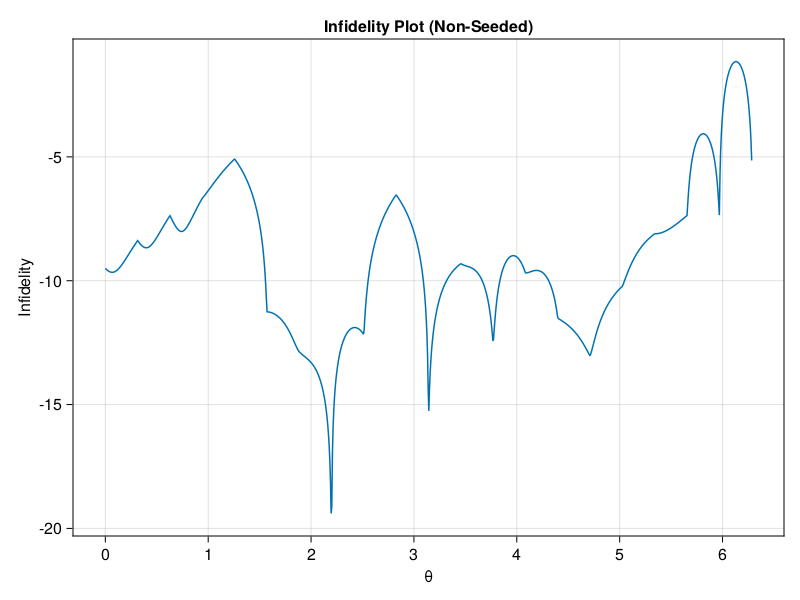

In [16]:
f = Figure()
ax = Axis(f[1, 1],
    title = "Infidelity Plot (Non-Seeded)",
    xlabel = "θ",
    ylabel = "Infidelity"
)
lines!(ax, range(0,2*pi,1000), log.(convert(Array{Float64,1},DATA)))
f

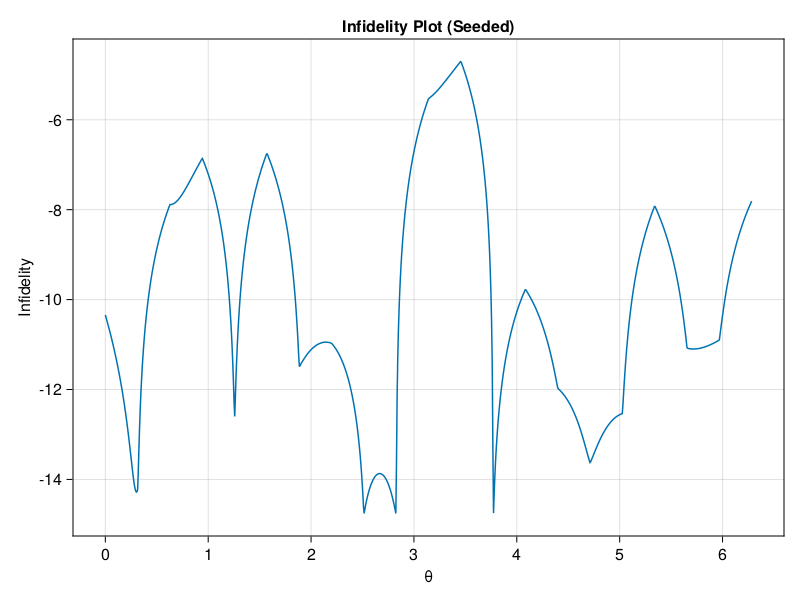

In [17]:
f = Figure()
ax = Axis(f[1, 1],
    title = "Infidelity Plot (Seeded)",
    xlabel = "θ",
    ylabel = "Infidelity"
)
lines!(ax, range(0,2*pi,1000), log.(convert(Array{Float64,1},initialized_DATA)))
f